In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal as mnormal
from scipy.stats import wishart
from scipy.special import logsumexp, digamma
from numpy.linalg import slogdet


# Let's now try a mixture of Gaussians using SVI!

We'll start with the Old Faithful dataset, so we can debug easily, then move on to something larger...

In [2]:
df = pd.read_csv('faithful.csv')
del df['Unnamed: 0']
old_faithful = df.to_numpy() 
old_faithful = old_faithful - np.expand_dims(np.mean(old_faithful, 0), 0)
old_faithful = old_faithful / np.expand_dims(np.std(old_faithful, 0), 0)

## Recap of the MoG updates from last time:


### $q^*(z_i) = Multinomial(\gamma_{1,i}, \dots, \gamma_{i, K})$
where
$$
\gamma_{i,c} \propto \exp\left\{ \frac{1}{2}\left(\psi_D\left(\frac{\nu_c}{2}\right) + \log|W_c| + \nu_c(x_i-m_c)^TW_c(x_i-m_c) + \frac{D}{\beta_c}\right) + \psi\left(\tau_c\right) - \psi\left(\sum_c\tau_c\right)  \right\}
$$



### $q^*(\pi) = Dirichlet(\tau_1,\dots, \tau_K)$

Where $\tau_c = \alpha + \sum_i \gamma_{i, c}$

 ### $q^*(\mu_c, \Lambda_c) = N(\mu_c|m_1, (\beta_{c}\Lambda_c)^{-1})Wishart(\Lambda_c|W_c, \nu_c)$
 
where
* $\nu_c = \nu + \tilde{\gamma}_c$
* $W_c^{-1} = W^{-1} +  \frac{\beta\tilde{\gamma}_c}{\beta+\tilde{\gamma}_c}\left(\frac{\tilde{x}_c}{\tilde{\gamma}_c} - \mu_0\right)\left(\frac{\tilde{x}_c}{\tilde{\gamma}_c} - \mu_0\right)^T + \sum_i \gamma_{i,c}\left(x_i-\frac{\tilde{x}_c}{\tilde{\gamma}_c}\right)\left(x_i-\frac{\tilde{x}_c}{\tilde{\gamma}_c}\right)^T$
* $\beta_c = \beta + \tilde{\gamma}_c$
* $ m_c = \frac{\beta \mu_0 + \tilde{x}_c}{\beta+\tilde{\gamma}_c}$
* $\tilde{\gamma}_c = \sum_i \gamma_{c,i}$
* $\tilde{x}_c = \sum_i \gamma_{c, i} x_i$

# I'm going to write out a cleaned-up version of the code from last time, for reference...



In [3]:
def multidigamma(a, d):
    """
    Returns the derivative of the log of multivariate gamma.
    """
    
    f = 0.
    for i in range(1, d+1):
        f += digamma(a +(1.-i)/2.)
    return f

def plot_clusters(data, probs, dims=[0,1]):
    hard_assignments = np.argmax(probs, 1) # get the most likely cluster
    num_clusters = probs.shape[1]
    for cluster in range(num_clusters):
        plt.scatter(data[hard_assignments==cluster, dims[0]], data[hard_assignments==cluster, dims[1]])
        
    plt.show()

class MOG:
    def __init__(self, K, D, hyper_params=None):
        # hyper_params: optional dict of hyper params with keys mu0, W0, alpha, beta0, nu0
        self.num_clusters = K
        self.D = D
        if hyper_params is None:
            # set some default values
            self.mu0 = np.zeros(self.D)
            self.W0 = np.eye(self.D)
            self.alpha = 1.
            self.beta0 = 1.
            self.nu0 = self.D + 1
        else:
            self.mu0 = hyper_params['mu0']
            self.W0 = hyper_params['W0']
            self.alpha = hyper_params['alpha']
            self.beta0 = hyper_params['beta0']
            self.nu0 = hyper_params['nu0']
        self.invW0 = np.linalg.inv(self.W0)
        # initialize the global parameters
        self.tau = np.random.dirichlet(self.alpha*np.ones(self.num_clusters))#np.ones(self.num_clusters)#
        self.m_c = {}
        self.W_c = {}
        self.beta_c = 0.5+np.random.rand(self.num_clusters)#np.ones(self.num_clusters)#
        self.nu_c = self.D*np.ones(self.num_clusters) + 3*np.random.rand(self.num_clusters)# 1#
        for cluster in range(self.num_clusters):
            self.W_c[cluster] = wishart.rvs(scale=self.W0, df=self.nu0)#np.eye(self.D)
            self.m_c[cluster] = mnormal.rvs(self.mu0, np.eye(self.D))#self.W_c[cluster])
            
    def calculate_local_parameters(self, x):
        return None
    
    def calculate_global_parameters(self, x, gamma):
        pass
    

class CAVI_MOG(MOG):
    def __init__(self, K, D, hyper_params=None):
        MOG.__init__(self, K, D, hyper_params=hyper_params)

    def calculate_local_parameters(self, x):
        N, _ = x.shape

        log_gammas = np.zeros((N, self.num_clusters))
        for cluster in range(self.num_clusters):
            E_ln_pi = digamma(self.tau[cluster]) - digamma(np.sum(self.tau))
            E_ln_det_Lam = multidigamma(self.nu_c[cluster]/2, self.D) + self.D*np.log(2) + slogdet(self.W_c[cluster])[1]
            for n in range(N):
                log_gammas[n, cluster] = log_gammas[n, cluster] - 0.5*self.nu_c[cluster]*np.dot(x[n, :] - self.m_c[cluster], np.dot(self.W_c[cluster], x[n, :] - self.m_c[cluster] ))
            
            log_gammas[:, cluster] = log_gammas[:, cluster] + 0.5*E_ln_det_Lam + E_ln_pi- D/(2*self.beta_c[cluster])
            
        ll = logsumexp(log_gammas, 1)
        log_gammas = log_gammas - np.expand_dims(ll, 1)
        gammas = np.exp(log_gammas)
        return gammas
    
    def update_global_params(self, x, gamma):
        N, _ = x.shape
        
        gamma_tilde = np.sum(gamma, 0) 
        self.nu_c = self.nu0 + gamma_tilde
        self.beta_c = self.beta0 + gamma_tilde
        self.tau = self.alpha*np.ones(self.num_clusters) + gamma_tilde
        for cluster in range(self.num_clusters):
            x_tilde_c = np.dot(gamma[:, cluster], x)
            r_c = np.zeros(x_tilde_c.shape)
            r_c[x_tilde_c!=0] = x_tilde_c[x_tilde_c!=0]/gamma_tilde[cluster] # avoiding divide-by-zero
            self.m_c[cluster] = (self.beta0*self.mu0 + x_tilde_c)/(self.beta0 + gamma_tilde[cluster])
            
            W_c_inv = self.invW0 + (self.beta0 * gamma_tilde[cluster] / (self.beta0 + gamma_tilde[cluster])) * np.outer((r_c - self.mu0), r_c - self.mu0)
            for i in range(N):
                W_c_inv += gamma[i, cluster] * np.outer(x[i, :] - r_c, x[i, :] - r_c)
            self.W_c[cluster] = np.linalg.inv(W_c_inv)
    
        

# Let's check it works...

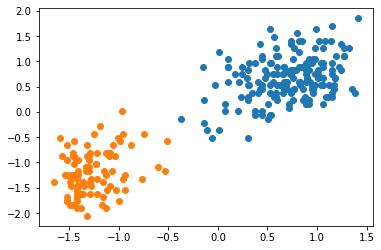

In [4]:
max_iters = 100
N, D = old_faithful.shape
cavi = CAVI_MOG(2, D)
for it in range(max_iters):
    gamma = cavi.calculate_local_parameters(old_faithful)
    cavi.update_global_params(old_faithful, gamma)
    
plot_clusters(old_faithful, gamma)    

# Great!! Now, on to SVI.

### Our SVI algorithm will look like:

* Initialize global parameters $\lambda^{(0)}=(\{\nu_c^{(0)}, W_c^{(0)}, \beta_c^{(0)}, m_c^{(0)}\}, \tau^{(0)})$ randomly
* Select step size schedule $\rho_t$
* For $t=1,2,\dots$:
    * Randomly select a size-$m$ minibatch $x^{(s)}$ (which might have $m=1$) 
    * For each $x_i\in x^{(s)}$, calculate it's optimal local $\gamma_{i,c}$ (as for CAVI)
    * Calculate estimate $\hat{\lambda}$ to the optimal global parameters, assuming all $N$ datapoints "look like: our minibatch.
    * Update the global parameters as $\lambda^{(t)} = (1-\rho_t) \lambda^{(t-1)} + \rho_t\hat{\lambda}$
    
TODO: What form do the $\hat{\lambda}$ take?

* $\hat{\nu}_c = $
* $\hat{W}_c^{-1} = $ (Note... $W_c^{-1}$ is the appropriate natural parameter for $\Lambda$, not $W_c$)
* $\hat{\beta}_c = $
* $\hat{m}_c = $
* $\hat{\tau} = $


For our schedule, we will use $\rho_t = (t+\tau)^{-\kappa}$ for some $\kappa \in (0.5, 1]$ and $\tau\geq 1$. You can pick these!

# First, let's write a data loader that can generate our minibatches

"Vanilla" SVI uses single observations per iteration, but we can also use size-$m$ minibatches. So, this will spit out a $m\times D$ random minibatch

In [5]:
class DataLoader:
    def __init__(self, data, minibatch_size=1, random=True):
        # if you set random=False, then it will just permute the data -- not truely random, but a bit faster
        self.N, self.D = data.shape
        self.random=random
        if self.random:
            self.x = data
        else:
            self.x = np.random.permutation(data)
            self.pointer = 0
            
        
    def sample_minibatch(self, minibatch_size):
        if self.random:
            idx = np.random.choice(self.N, minibatch_size, replace=False)
            return self.x[idx, :]
        batch = self.x[self.pointer:self.pointer+minibatch_size]
        self.pointer += minibatch_size
        if self.pointer > self.N:
            self.pointer=0
        return batch

# Next, write your SVI class

It should be fairly minimal modification of the CAVI class!


In [ ]:
class SVI_MOG(MOG):
    def __init__(self, K, D, hyper_params=None):
        MOG.__init__(self, K, D, hyper_params=hyper_params)

    def calculate_local_parameters(self, x):
        # x is our m x D minibatch
        # TODO
        return gamma
    
    def update_global_params(self, x, gamma, N, rho):
        # x is our m x D minibatch
        # gamma is the corresponding gammas
        # N is the overall data size (why do we need this?)
        # rho is the current step size parameter
        
        # TODO
        
        # This shouldn't return anything, unless you want something for plotting

# Check it works! 

If you've written it right, the following should give you the same thing as before more-or-less

(Or debug until it does...)

In [ ]:
tau = #Your choice of positive number... you can try different values. The paper's default is 1.
kappa = # Your choice in (0.5, 1]

max_iters = 1000
N, D = old_faithful.shape
svi = SVI_MOG(2, D)

dataloader = DataLoader(old_faithful)
minibatch_size=1
for it in range(max_iters):
    minibatch = dataloader.sample_minibatch(minibatch_size)
    gamma = svi.calculate_local_parameters(minibatch)
    tau = (it + 1 + tau)**(-kappa)
    svi.update_global_params(minibatch, gamma, N, tau)

full_gamma = svi.calculate_local_parameters(old_faithful)
plot_clusters(old_faithful, full_gamma)   

# OK, let's try on something big!!

Download mnist.py from https://github.com/hsjeong5/MNIST-for-Numpy and save it in this directory or somewhere in your path, so we can easily load the MNIST dataset

In [6]:
import mnist
mnist.init()
x_train, t_train, x_test, t_test = mnist.load()
x_train = x_train / 255.

Download complete.
Save complete.


## Let's take a look at what the data looks like.

I've scaled it to (0, 1)

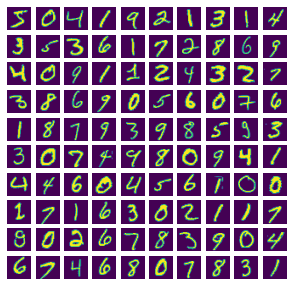

In [7]:
fig, ax = plt.subplots(10,10, figsize=(5,5))
c=0
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(x_train[c, :].reshape(28,28))
        ax[i,j].axis("off")
        c+=1
plt.show()

# OK let's try it!

It's going to be pretty slow, because $D=784$ and we have a bunch of terms that are cubic in $D$.

If your computer isn't happy, or your patience is thin, you could try running PCA on the data and using the top 100 components -- I found this ran a lot quicker while still giving decent cluster means! You can use the sklearn PCA function to get the decomposition

Or, you could try using spherical covariances, like our first CAVI example (but learning the variances and proportions)

In [ ]:
tau = 1 # Your choice of positive number... you can try different values. The paper's default is 1.
kappa = 0.6 # Your choice in (0.5, 1]. I just picked arbitrarily

# I found 200 iterations with 10 minibatches gave OK results... you can vary this though!
max_iters = 200 
minibatch_size=10

N, D = x_train.shape
num_clusters = 10 # you can change this, but be sure to change the plotting code snippet at the end to match

svi = SVI_MOG(num_clusters, D)

dataloader = DataLoader(x_train)

for it in range(max_iters):
    minibatch = dataloader.sample_minibatch(minibatch_size)
    gamma = svi.calculate_local_parameters(minibatch)
    tau = (it + 1 + tau)**(-kappa)
    svi.update_global_params(minibatch, gamma, N, tau)
    if it % 10 == 0:
        print(it)

fig, ax = plt.subplots(2,5, figsize=(5,5))
c=0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(svi.m_c[c].reshape(28,28))
        ax[i,j].axis("off")
        c+=1
plt.show()